In [13]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
def f(x):
    return 3*x**2 - 4*x + 5

In [4]:
f(3.0)

20.0

In [5]:
xs = np.arange(-5, 5, 0.25)
xs

array([-5.  , -4.75, -4.5 , -4.25, -4.  , -3.75, -3.5 , -3.25, -3.  ,
       -2.75, -2.5 , -2.25, -2.  , -1.75, -1.5 , -1.25, -1.  , -0.75,
       -0.5 , -0.25,  0.  ,  0.25,  0.5 ,  0.75,  1.  ,  1.25,  1.5 ,
        1.75,  2.  ,  2.25,  2.5 ,  2.75,  3.  ,  3.25,  3.5 ,  3.75,
        4.  ,  4.25,  4.5 ,  4.75])

In [6]:
ys = f(xs)
ys

array([100.    ,  91.6875,  83.75  ,  76.1875,  69.    ,  62.1875,
        55.75  ,  49.6875,  44.    ,  38.6875,  33.75  ,  29.1875,
        25.    ,  21.1875,  17.75  ,  14.6875,  12.    ,   9.6875,
         7.75  ,   6.1875,   5.    ,   4.1875,   3.75  ,   3.6875,
         4.    ,   4.6875,   5.75  ,   7.1875,   9.    ,  11.1875,
        13.75  ,  16.6875,  20.    ,  23.6875,  27.75  ,  32.1875,
        37.    ,  42.1875,  47.75  ,  53.6875])

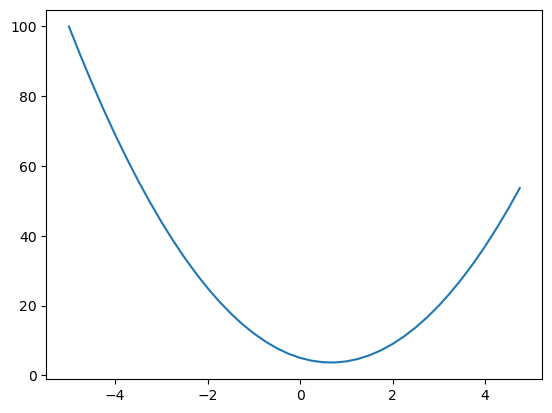

In [7]:
plt.plot(xs, ys)

In [8]:
h = 0.000000001
x = -3.0
(f(x+h) - f(x)) / h

-22.000001820288162

In [9]:
h = 0.000000001

a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
a += h
d2 = a*b + c
print('d1', d1)
print('d2', d2)
print('slope', (d2 - d1)/h)

d1 4.0
d2 3.9999999969999998
slope -3.000000248221113


In [21]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out

    def __radd__(self, other):
        return self + other

    def __sub__(self, other):
        return self + (-other)

    def __neg__(self):
        return self * -1

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out

    def __rmul__(self, other):
        return self * other

    def __truediv__(self, other):
        return self * other**-1

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "must be int/float power"
        out = Value(self.data**other, (self,), f'**{other}')
        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad
        out.backward = _backward
        return out

    def tanh(self):
        n = self.data
        t = (math.exp(2*n) - 1) / (math.exp(2*n) + 1)
        out = Value(t, (self, ), 'tanh')
        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        return out

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')
        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        return out

    def backward(self):
        topo = []
        visited = set()
        def build_topo(v: Value):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        for node in reversed(topo):
            node._backward()


In [37]:
a = Value(2.0)
print(a.tanh())

e = (2*a).exp()
(e - 1) / (e + 1)

Value(data=0.9640275800758169)


Value(data=0.9640275800758169)

In [24]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name = uid + n._op, label = n._op)
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot


In [26]:
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

b = Value(6.8813735870195432, label='b')

x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'

n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

o.grad = 1.0

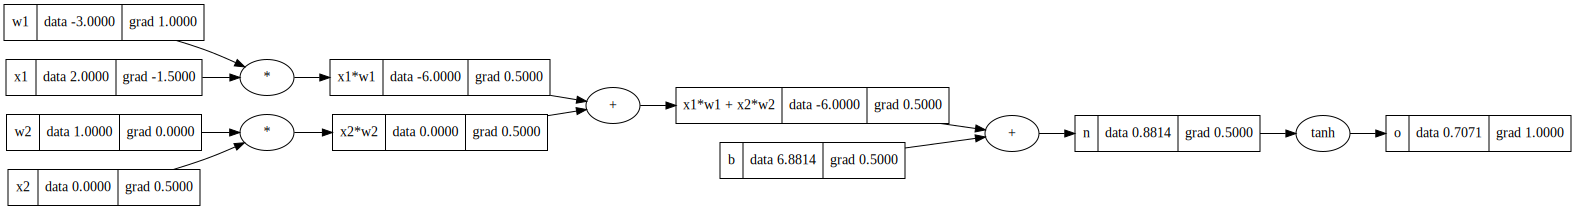

In [27]:
o.backward()
draw_dot(o)

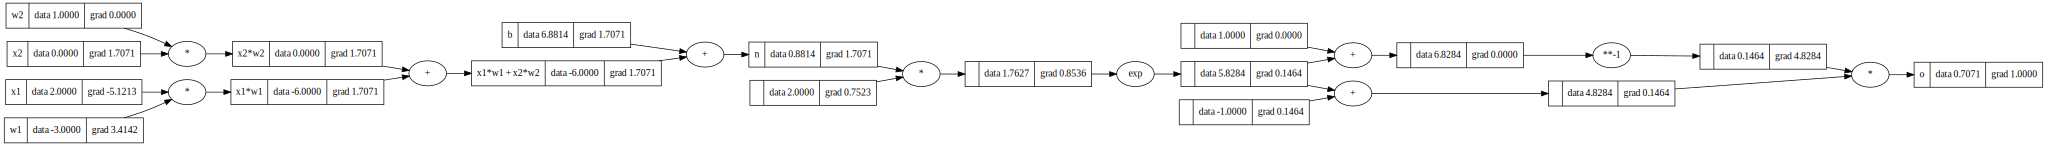

In [39]:
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

b = Value(6.8813735870195432, label='b')

x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'

n = x1w1x2w2 + b; n.label = 'n'

e = (2*n).exp()
o = (e - 1) / (e + 1)
o.label = 'o'

o.grad = 1.0
o.backward()
draw_dot(o)

In [50]:
import torch
import random

x1 = torch.Tensor([2.0]).double(); x1.requires_grad = True
x2 = torch.Tensor([0.0]).double(); x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double(); w1.requires_grad = True
w2 = torch.Tensor([1.0]).double(); w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double(); b.requires_grad = True

n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [93]:
class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))

    def __call__(self, x):
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out

    def parameters(self):
        return self.w + [self.b]

class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

x = [2.0, 3.0, -1]
n = MLP(3, [4, 4, 1])

In [114]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0]

ypred = [n(x) for x in xs]
ypred

[Value(data=-0.06800227758744672),
 Value(data=-0.7482071229585097),
 Value(data=-0.5968627275090463),
 Value(data=-0.8036574508570833)]

In [107]:
loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, ypred)])
loss

Value(data=4.619728378364521)

In [112]:
loss.backward()

In [113]:
n.layers[0].neurons[0].w[0].grad

0.0

In [115]:
for p in n.parameters():
    p.data += -0.01 * p.grad
